# aQa Final Project: Qualitive comparison of Quantum Neural Networks and Classical Neural Networks

Firstly, import the correct libraries and set the random seed. This may take some time. <br>
Make sure the correct versions are installed (see requirements.txt).

In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

np.random.seed(19)

2024-05-02 14:18:15.186335: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-05-02 14:18:15.186589: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-05-02 14:19:04.533285: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-05-02 14:19:04.533333: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-05-02 14:19:04.533351: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-US2QGPT7): /proc/driver/nvidia/version does not exist
2024-05-02 14:19:04.540667: I tensorflow/core/platform/cpu_fe

Next, we will define the depth and the number of qubits. We can sweep these variables later. <br>
We can also generate the rotations that will generate the randomd data.

In [2]:
depth = 4
n_qubits = 3

randomRotations = np.random.uniform(-2*np.pi , 2 * np.pi, (depth * n_qubits))

## Quantum Neural network

In [3]:
def buildQuantumModel(encoding: np.array, parameters: np.array, depth : int, n_qubits : int) -> None:
    qubits = cirq.LineQubit.range(n_qubits)

    #encoding layer
    yield [cirq.rz(encoding[i])(qubits[i]) for i in range(n_qubits)]
    yield [cirq.ry(encoding[i])(qubits[i]) for i in range(n_qubits)]
    yield [cirq.rx(encoding[i])(qubits[i]) for i in range(n_qubits)]

    #variational layer
    for l in range(depth):
        for i in range(n_qubits):
            yield cirq.rx(parameters[i + l*n_qubits])(qubits[i])
        for i in range(n_qubits-1):
            yield cirq.CZ(qubits[i], qubits[i+1])



simulator = cirq.Simulator()

As the quantum neural network output needs to be simulated, we will use the statevector simulator. <br>

In [4]:
def runCircuit(data : np.array, parameters : np.array) -> float:


    quantumModel = cirq.Circuit(buildQuantumModel(data, parameters, depth, n_qubits))
    result = simulator.compute_amplitudes(quantumModel, bitstrings=[2**n_qubits-1])

    norm = np.linalg.norm(result)

    return norm

## Classical Neural network

In [18]:
def buildClassicalModel(depth : int , trainable : bool) -> tf.keras.Sequential:

    classicModel = tf.keras.Sequential()

    for l in range(depth):
        classicModel.add(tf.keras.layers.Dense(n_qubits, activation='relu', trainable=trainable))

    classicModel.add(tf.keras.layers.Dense(1, activation='relu', trainable=trainable))

    return classicModel

classicModel = buildClassicalModel(depth, True)
dataClassicalModel = buildClassicalModel(depth, False)

## Data generation

Generate some data within the range of 0 and 2 pi. <br>

In [19]:
def generateSamples(samples : int) -> np.array:

    empty = np.array([])

    for i in range(samples):
        empty = np.append(empty, np.random.uniform(-2* np.pi , 2 * np.pi, 2))

    empty = empty.reshape(samples, 2)

    data = np.zeros((empty.shape[0], empty.shape[1] + 1))
    data[:,:2] = empty
    data[:,-1] = empty[:,0]*empty[:,1]

    return data

#print(generateSamples(10))

Feed into the untrained quantum neural network and the classical neural network. <br>

In [20]:
dataClassicalModel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
data = generateSamples(100)

classicLabels = dataClassicalModel.predict(data)
onelabel = zerolabel = 0

for i in range(len(classicLabels)):
    if classicLabels[i] > 0.5:
        classicLabels[i] = 1
        onelabel += 1
    else:
        classicLabels[i] = 0
        zerolabel += 1

print("1s: ", onelabel)
print("0s: ", zerolabel)

1s:  40
0s:  60


<Axes: >

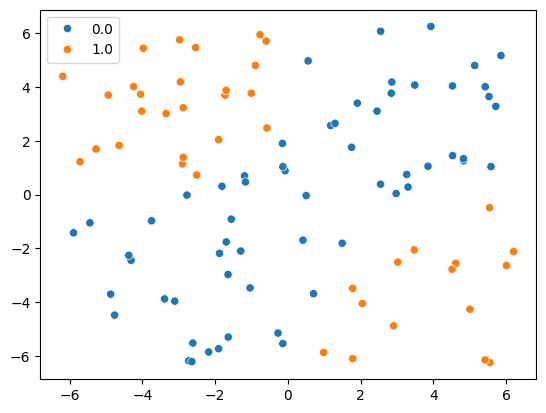

In [21]:
#plot the data points
fig, ax = plt.subplots()
sns.scatterplot(x=data[:,0], y=data[:,1], hue=classicLabels.flatten(), ax=ax)

In [22]:
quantumLabels = [runCircuit(data[i,:], randomRotations) for i in range(len(data))]

onelabel = zerolabel = 0

for i in range(len(quantumLabels)):
    if quantumLabels[i] > 0.5:
        quantumLabels[i] = 1
        onelabel += 1
    else:
        quantumLabels[i] = 0
        zerolabel += 1

print("1s: ", onelabel)
print("0s: ", zerolabel)

1s:  4
0s:  96


<Axes: >

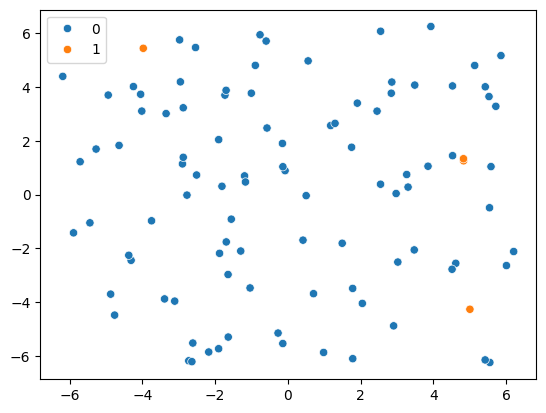

In [23]:
fig, ax = plt.subplots()
sns.scatterplot(x=data[:,0], y=data[:,1], hue=quantumLabels, ax=ax)

## Training